## **Notebook for building and training of GNN model for energy prediction of BP GBs (Complete DFT Dataset)**




**Installing PyTorch Geometric (PyG).**



1.   GNN model tested on PyTorch 1.11 & CUDA 11.3
2.   Please check and make sure the version in the `pip install ...` command is consistent with the current version in the Google Colab.
3. If the version is not consistent `${CUDA}` and `${TORCH}` should be replaced by the current CUDA version (e.g. cu113, cu115) and PyTorch version (e.g. 1.10.0, 1.11.0), respectively.
4.   Details for installation can be found at [documentation of PyTorch-Geometric](https://pytorch-geometric.readthedocs.io/en/latest/index.html).



In [1]:
print('Current version: ')  # Check the current PyTorch & CUDA version 
import torch; print(torch.__version__) 
import torch; print(torch.version.cuda)
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html

Current version: 
1.11.0+cu113
11.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 7.9 MB 6.4 MB/s 
     |████████████████████████████████| 3.5 MB 29.4 MB/s 
     |████████████████████████████████| 2.5 MB 14.1 MB/s 
     |████████████████████████████████| 750 kB 30.2 MB/s 
     |████████████████████████████████| 407 kB 8.1 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=0fe5d1239767f761a69edce20914a23c02a0cfdbdfdde7b25673d92cefa1e1e9
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric


**Install the Atomic Simulation Enviroment**

In [2]:
!pip install ase

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.2 MB 9.3 MB/s 


**Import the essential packages**

In [3]:
import numpy as np
import pandas as pd
import networkx as nx
from os import listdir
from ase.io import read
from copy import deepcopy
from random import shuffle
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from os.path import dirname, join, isdir
from torch_geometric.utils import from_networkx 
from torch_geometric.data import Data, DataLoader

Mount Google Drive allows save models in it.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Download the Complete DFT Dataset discussed in the paper**

*   Unrelaxed and relaxed structures are downloaded seperately.

In [4]:
!gdown https://drive.google.com/uc?id=1_Zg8wWlwcY4GNguObWYj3fCBAGuw4lV8  # Unrelaxed structures
!gdown https://drive.google.com/uc?id=1reqcL65gXVF4VTE3zFlN3PowzqF-sWSY  # Relaxed structures

Downloading...
From: https://drive.google.com/uc?id=1_Zg8wWlwcY4GNguObWYj3fCBAGuw4lV8
To: /content/unrelaxed_bp_gb_dft.zip
100% 137M/137M [00:00<00:00, 148MB/s]
Downloading...
From: https://drive.google.com/uc?id=1reqcL65gXVF4VTE3zFlN3PowzqF-sWSY
To: /content/relaxed_bp_gb_dft.zip
100% 141M/141M [00:00<00:00, 141MB/s]


**Unzip the downloaded zip files for BP GB structures**

In [5]:
import zipfile
with zipfile.ZipFile('/content/unrelaxed_bp_gb_dft.zip', 'r') as zip_ref:  # Unrelaxed structures
    zip_ref.extractall('/content/unrelaxed_bp_gb_dft')

In [6]:
import zipfile
with zipfile.ZipFile('/content/relaxed_bp_gb_dft.zip', 'r') as zip_ref:  # Relaxed structures
    zip_ref.extractall('/content/relaxed_bp_gb_dft')

**Functions for transferring POSCAR to graph and Data objects in PyG.**
*  3.3 Å bond length cutoff is used.

In [9]:
# Function that transfer POSCAR file to graph object using NetWorkX
def struc2graph_dft(file, cutoff, format='vasp', pbc=[True, False, False], 
                atom_force=False, get_energy=False):


    # create the graph object
    graph = nx.Graph()

    # get the positions for all the atoms in the file
    # ASE can auto detect the file format
    if format is not None:
        atom_obj = read(file, format=format)
    else:
        atom_obj = read(file)
    
    # assign the Atom object as one of the feature to the graph
    #graph.graph['atom_obj'] = atom_obj

    # if read atom force, try to read atom force from force_on_atom file
    if atom_force:
      try:
        with open(join(dirname(file), 'force_on_atom_detail'), 'r') as f:
          f_lines = f.readlines()
      except FileNotFoundError:
        print('Can\'t read force_on_atom_detail file in directory.')
    else:
      pass
      #print('Do not read atom forces.')


    # if the periodic neighbor cell need to be considered, need to also make neighbor cells
    # make cell a one dimensial vector
    cell = []
    cell.append(atom_obj.get_cell()[0][0])
    cell.append(atom_obj.get_cell()[1][1] - 8) # Change the cell back to the original size
    cell.append(atom_obj.get_cell()[2][2])
    cell = np.array(cell)
    ori_atom_pos = atom_obj.get_positions()

    # calculate the pairs that within the bond length cutoff for the original cell
    atom_num = len(ori_atom_pos)
    for i in range(atom_num):
        #print(cell.shape)
        feature_vector = np.append(cell, ori_atom_pos[i] / cell)
        #graph.add_node(i, x = np.append(feature_vector, force_vector))
        graph.add_node(i, x = feature_vector)
        for j in range(atom_num):
            distance = np.sqrt((ori_atom_pos[i][0] - ori_atom_pos[j][0]) ** 2 +
                               (ori_atom_pos[i][1] - ori_atom_pos[j][1]) ** 2 +
                               (ori_atom_pos[i][2] - ori_atom_pos[j][2]) ** 2)
            if distance <= cutoff and distance != 0:
                graph.add_edge(i, j, distance=distance)

    # consider the atoms in neighbor cell
    if pbc[0]:
        x_adj_atom_pos = deepcopy(ori_atom_pos)
        x_adj_atom_pos[:, 0] = x_adj_atom_pos[:, 0] + cell[0]

        for i in range(atom_num):
            for j in range(atom_num):
                distance = np.sqrt((ori_atom_pos[i][0] - x_adj_atom_pos[j][0]) ** 2 +
                                   (ori_atom_pos[i][1] - x_adj_atom_pos[j][1]) ** 2 +
                                   (ori_atom_pos[i][2] - x_adj_atom_pos[j][2]) ** 2)
                if distance <= cutoff and distance != 0:
                    graph.add_edge(i, j, distance=distance)

    # consider the atoms in neighbor cell y direction
    if pbc[1]:
        y_adj_atom_pos = deepcopy(ori_atom_pos)
        y_adj_atom_pos[:, 0] = y_adj_atom_pos[:, 0] + cell[1]

        for i in range(atom_num):
            for j in range(atom_num):
                distance = np.sqrt((ori_atom_pos[i][0] - y_adj_atom_pos[j][0]) ** 2 +
                                   (ori_atom_pos[i][1] - y_adj_atom_pos[j][1]) ** 2 +
                                   (ori_atom_pos[i][2] - y_adj_atom_pos[j][2]) ** 2)
                if distance <= cutoff and distance != 0:
                    graph.add_edge(i, j, distance=distance)

    return graph


# Function for get the total energy of structure
def get_tot_e(output_path):
    """
    :param output_path: the path to the LAMMPS output log file
    :return: return the total energy that read from the log file
    """
    # read the vasprun.xml file 
    vasp_out = read(output_path, format='vasp-xml')

    return vasp_out.get_potential_energy()


# Function for generate the dataset list
def dataset_list(target_folder, cutoff, relax_folder, atom_force=False):
  dataset_list = []
  for struc_folder in tqdm(listdir(target_folder)):
    if isdir(join(target_folder, struc_folder)):
      
      poscar_path = join(target_folder, struc_folder, 'CONTCAR')
      vaspxml_path = join(target_folder, struc_folder, 'vasprun.xml')
      try:
        tot_e = get_tot_e(vaspxml_path)
      except:
        print(struc_folder)
        continue
      data = struc2graph_dft(poscar_path, cutoff, atom_force=atom_force)
      data = from_networkx(data)
      data.y = torch.tensor(np.array([tot_e]))
      data.relax = relax_folder
      atom_obj = read(poscar_path, format='vasp')
      data.atom_obj = atom_obj
      dataset_list.append(data)

  return dataset_list

relax_dataset = dataset_list('/content/relaxed_bp_gb_dft/relaxed_bp_gb_dft', 3.3, True)
unrelax_dataset = dataset_list('/content/unrelaxed_bp_gb_dft/unrelaxed_bp_gb_dft', 3.3, False)


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/2188 [00:00<?, ?it/s]

**The *complete DFT dataset* that can be load by PyG dataset loader.**

In [10]:
complete_dft_dataset = relax_dataset + unrelax_dataset

**Basic information and the distribution plot of complete DFT dataset**

count    2188.000000
mean     -325.219912
std         8.405709
min      -348.560408
25%      -331.924646
50%      -323.881354
75%      -318.186999
max      -305.218789
dtype: float64
count    2188.000000
mean     -349.491583
std         8.630487
min      -375.316069
25%      -355.036897
50%      -349.229183
75%      -343.435424
max      -325.703431
dtype: float64


(array([  0.,  50., 100., 150., 200., 250., 300.]),
 <a list of 7 Text major ticklabel objects>)

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


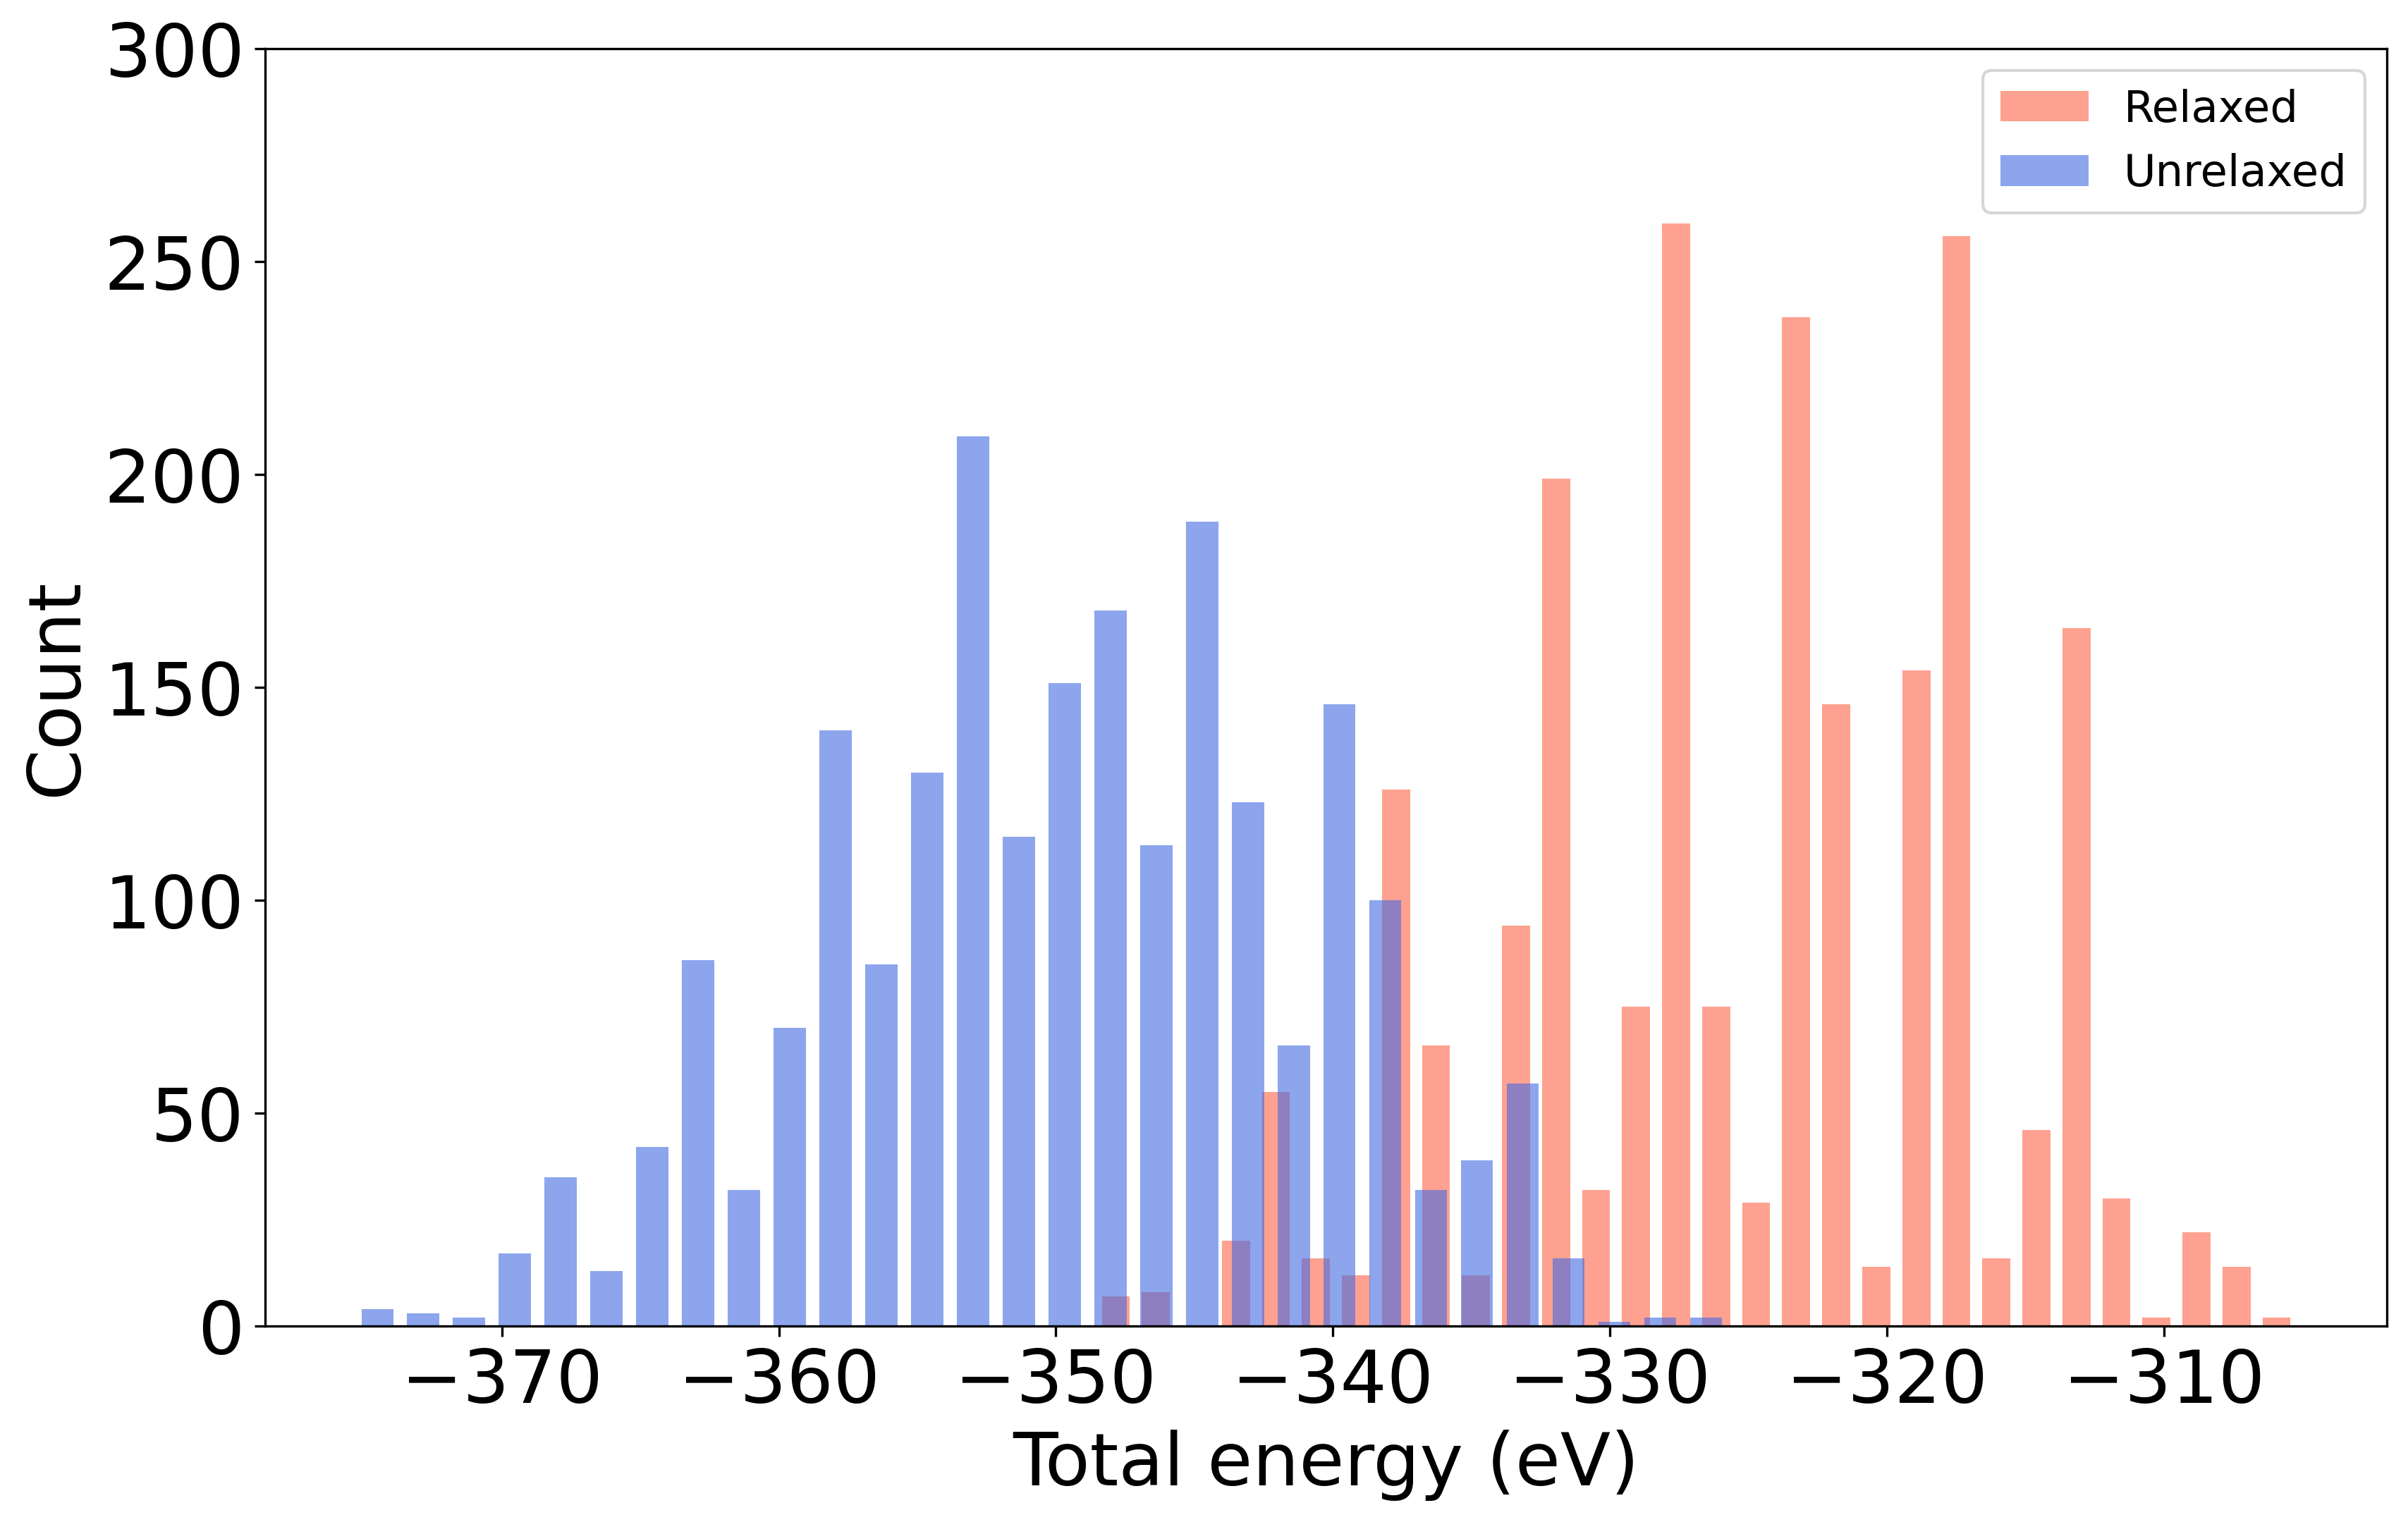

In [11]:
%matplotlib inline

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 15

plt.rc('axes', titlesize=25)         # fontsize of the axes title
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig = plt.figure(figsize=(12.944, 8), dpi=300)
#fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot(111)

y_relaxed_list = [_.y.item() for _ in complete_dft_dataset if _.relax]
y_unrelaxed_list = [_.y.item() for _ in complete_dft_dataset if not _.relax]

relax_s = pd.Series(y_relaxed_list)
unrelax_s = pd.Series(y_unrelaxed_list)
print(relax_s.describe())
print(unrelax_s.describe())

ax.set_ylim(0, 300)
ax.set_xlabel('Total energy (eV)', fontname='Helvetica')
ax.set_ylabel('Count', fontname='Helvetica')
ax.hist(y_relaxed_list, bins=30, alpha=0.6, label='Relaxed', color='tomato', rwidth=0.7)
ax.hist(y_unrelaxed_list, bins=30, alpha=0.6, label='Unrelaxed', color='royalblue', rwidth=0.7)
ax.legend()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

**The GNN model based on the GIN convolution layers as discussed in the paper.**

In [12]:
import torch.nn.functional as F
print(torch.__version__)

# The PyG built-in GINConv
from torch_geometric.nn import GINConv, global_mean_pool, global_add_pool

class GIN(torch.nn.Module):
    def __init__(self, input_dim, conv_hidden_dim, linear_hidden_dim, 
                 node_output_dim, graph_output_dim, conv_num_layers,
                 dropout, task='graph'):
        # implement this function that initializes the layers for node embeding
    
        super(GIN, self).__init__()

        # probability of an element to be zeroed
        self.dropout = dropout

        # determine the output dimension from task
        self.task = task
        if self.task == 'graph':
          output_dim = graph_output_dim
        elif self.task == 'node':
          output_dim = node_output_dim

        # number of layers can be modified later
        self.conv_num_layers = conv_num_layers
        self.convs = torch.nn.ModuleList()

        # fisrt layer have different input chanel
        self.convs.append(self.build_conv(input_dim, conv_hidden_dim))

        for i in range(conv_num_layers - 1):
          self.convs.append(self.build_conv(conv_hidden_dim, conv_hidden_dim))

        # batch normalize layers
        self.bns = torch.nn.ModuleList()
        for i in range(conv_num_layers - 1):
          self.bns.append(torch.nn.BatchNorm1d(conv_hidden_dim))
        
        # post message passing layers after convolution (L in the paper)
        self.post_mp = torch.nn.Sequential(torch.nn.Linear(conv_hidden_dim, linear_hidden_dim),
                          torch.nn.ReLU(), 
                          torch.nn.Dropout(self.dropout),
                          torch.nn.Linear(linear_hidden_dim, output_dim),)
    
    def build_conv(self,in_dim, hidden_dim):  # MLP in every GIN layer
      return GINConv(torch.nn.Sequential(torch.nn.Linear(in_dim, hidden_dim), 
                    torch.nn.ReLU(),
                    torch.nn.Linear(hidden_dim, hidden_dim)), aggr='add')

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()
        for layer in self.post_mp:
          if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

    def forward(self, data):
        # implement this function that takes the feature tensor x,
        # edge_index tensor and returns the output tensor 

        x, edge_index, batch = data.x, data.edge_index, data.batch

        for i in range(self.conv_num_layers - 1):
          x = self.convs[i](x.float(), edge_index)
          x = self.bns[i](x)
          x = F.relu(x)
          x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)

        x = global_add_pool(x, batch)
        emb = x
        x = self.post_mp(x)

        return x, emb

1.11.0+cu113


**Function that enable training of model on a given set.**

In [13]:
# Function that train model on a given set with chosen optimizer and 
# loss function
def train(model, device, train_loader, optimizer, loss_fn):
  model.train()
  loss = 0
  avg_loss = 0
  
  for step, batch in enumerate(train_loader):
    batch = batch.to(device)

    optimizer.zero_grad()
    out, emb = model(batch)
    loss = loss_fn(out.squeeze(1), batch.y)
    loss.backward()
    optimizer.step()

    avg_loss += loss.item()
  
  avg_loss = avg_loss / len(train_loader)

  return avg_loss

**Function that enable testing of model on a given set.**

In [14]:
# Function that test a model on a given set with chosen loss function
def test(model, device, test_loader, eval_loss_fn):
  model.eval()
  y_true = []
  y_pred = []

  err = 0
  for step, batch in enumerate(test_loader):
    batch = batch.to(device)

    with torch.no_grad():
      pred, emb = model(batch)

    err += eval_loss_fn(pred.squeeze(1), batch.y).item()

  average_err = err / len(test_loader)

  return average_err


**Load the complete DFT dataset using PyG loader.**



1.   `train_num` is the number of structures that used for training among relaxed or unrelaxed structures.
2.   Rest of the structures are equally divided into validation and test sets.



In [16]:
from torch_geometric.utils import from_networkx 
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

# split the data list so the ratio is controlled
shuffle(relax_dataset)
shuffle(unrelax_dataset)

print(len(relax_dataset))
print(len(unrelax_dataset))

train_num = 950
relax_test_num = int((len(relax_dataset) - train_num) / 2)
unrelax_test_num = int((len(unrelax_dataset) - train_num) / 2)

train_list = relax_dataset[:train_num] + unrelax_dataset[:train_num]
validate_list = relax_dataset[train_num: train_num + relax_test_num] + unrelax_dataset[train_num: train_num + unrelax_test_num]
test_list = relax_dataset[train_num + relax_test_num:] + unrelax_dataset[train_num + unrelax_test_num:]

# Load the dataset 
train_loader = DataLoader(train_list, batch_size=128, shuffle=True)
validate_loader = DataLoader(validate_list, batch_size=128, shuffle=True)
test_loader = DataLoader(test_list, batch_size=128, shuffle=True)
plot_validate_loader = DataLoader(validate_list, batch_size=1, shuffle=True)
plot_test_loader = DataLoader(test_list, batch_size=1, shuffle=True)
compelete_loader = DataLoader(complete_dft_dataset, batch_size=1, shuffle=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: {}'.format(device))



2188
2188
Device: cuda


**Hyperparameters that used for the training.**

In [17]:
args = {
    'model': GIN, 
    'device': device,
    'input_dim': 6,
    'node_output_dim': 16,
    'graph_output_dim': 1,
    'conv_num_layers': 10,
    'conv_hidden_dim': 1024,
    'linear_hidden_dim': 1024,
    'dropout': 0.25,
    'lr': 0.0001,
    'lr_anealing': 0.8,
    'anealing_step': 5,
    'epochs': 100,
}

model = args['model'](args['input_dim'], args['conv_hidden_dim'], 
            args['linear_hidden_dim'], args['node_output_dim'],
            args['graph_output_dim'], args['conv_num_layers'], args['dropout']).to(device)


args

{'anealing_step': 5,
 'conv_hidden_dim': 1024,
 'conv_num_layers': 10,
 'device': 'cuda',
 'dropout': 0.25,
 'epochs': 100,
 'graph_output_dim': 1,
 'input_dim': 6,
 'linear_hidden_dim': 1024,
 'lr': 0.0001,
 'lr_anealing': 0.8,
 'model': __main__.GIN,
 'node_output_dim': 16}

**Traing the GNN model with previously loaded dataset:**



*   Model with the lowest mean absolute error (MAE) on validation set during 100 epochs will be recorded as the best model.



In [19]:
import copy
import numpy as np
from torch.optim.lr_scheduler import StepLR

model.reset_parameters()
for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

# define optimizer, loss function and the learning rate anealing method
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
scheduler = StepLR(optimizer, args['anealing_step'], gamma=args['lr_anealing'])
loss_fn = torch.nn.L1Loss()

best_model = None
best_mae = 10000
best_epochs = 0
train_mae_list = []
validate_mae_list = []

for epoch in range(1, 1 + args["epochs"]):

  print('Training...')
  loss = train(model, device, train_loader, optimizer, loss_fn)
  train_mae_list.append(loss)

  print('Testing...')
  train_result = test(model, device, train_loader, loss_fn)
  validate_result = test(model, device, validate_loader, loss_fn)

  scheduler.step()

  mae_train, mae_validate = train_result, validate_result
  validate_mae_list.append(mae_validate)
  if mae_validate < best_mae:
      best_mae = mae_validate
      best_model = copy.deepcopy(model)
      best_epoch = epoch
  print(f'Epoch: {epoch:02d}, '
        f'Average loss: {loss:.4f} eV square, '
        f'Training set MAE: {mae_train:.4f} eV, '
        f'Validation set MAE: {mae_validate:.4f} eV')

Training...
Testing...
Epoch: 01, Average loss: 108.7659 eV square, Training set MAE: 534.7353 eV, Validation set MAE: 548.1339 eV
Training...
Testing...
Epoch: 02, Average loss: 29.6682 eV square, Training set MAE: 72.2335 eV, Validation set MAE: 74.9173 eV
Training...
Testing...
Epoch: 03, Average loss: 24.0566 eV square, Training set MAE: 37.9345 eV, Validation set MAE: 41.4364 eV
Training...
Testing...
Epoch: 04, Average loss: 21.3565 eV square, Training set MAE: 13.2494 eV, Validation set MAE: 13.8449 eV
Training...
Testing...
Epoch: 05, Average loss: 23.7976 eV square, Training set MAE: 31.4741 eV, Validation set MAE: 31.7532 eV
Training...
Testing...
Epoch: 06, Average loss: 19.0032 eV square, Training set MAE: 16.3564 eV, Validation set MAE: 16.6337 eV
Training...
Testing...
Epoch: 07, Average loss: 16.9946 eV square, Training set MAE: 29.9064 eV, Validation set MAE: 30.2272 eV
Training...
Testing...
Epoch: 08, Average loss: 19.9108 eV square, Training set MAE: 11.8194 eV, Vali

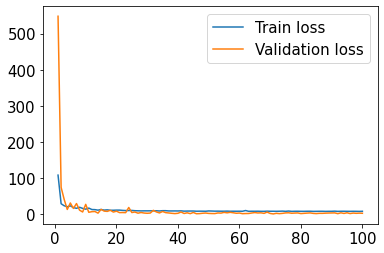

In [20]:
#import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

def plot_loss(epochs, train_loss, train_label, test_loss, test_label, start):
  plt.plot(epochs[start:], train_loss[start:], label=train_label)
  plt.plot(epochs[start:], test_loss[start:], label=test_label)
  plt.legend(loc='best')
  
epochs = np.arange(1, args['epochs'] + 1)
plot_loss(epochs, train_mae_list, 'Train loss', validate_mae_list, 'Validation loss', 0)

In [21]:
train_result = test(best_model, device, train_loader, loss_fn)
validate_result = test(best_model, device, validate_loader, loss_fn)
test_result = test(best_model, device, test_loader, loss_fn)
compelete_result = test(best_model, device, compelete_loader, loss_fn)

mae_train, mae_test, mae_compelete = train_result, test_result, compelete_result

print('Best epoch: ' + str(best_epoch))
print(f'Train MAE: {mae_train:.4f} eV, '
      f'Test MAE: {mae_test:.4f} eV, '
      f'Compelete MAE: {mae_compelete:.4f} eV')
args

Best epoch: 71
Train MAE: 1.5127 eV, Test MAE: 1.5449 eV, Compelete MAE: 1.5186 eV


{'anealing_step': 5,
 'conv_hidden_dim': 1024,
 'conv_num_layers': 10,
 'device': 'cuda',
 'dropout': 0.25,
 'epochs': 100,
 'graph_output_dim': 1,
 'input_dim': 6,
 'linear_hidden_dim': 1024,
 'lr': 0.0001,
 'lr_anealing': 0.8,
 'model': __main__.GIN,
 'node_output_dim': 16}

**Save the best model to the Google Drive**

*   Mount the Google Drive required for this step.
*   Best model file name can be changed by modify `best_model_name`



In [ ]:
best_model_name = 'best_model.pt'
torch.save(best_model, f'/content/drive/MyDrive/{best_model_name}')

In [ ]:
best_model = torch.load(f'/content/drive/MyDrive/{best_model_name}')

**Generate the parity plot of the best model on the test set.**


*   Performance of the best model evaluated on the test set.
*   MAE and percentage MAE also calculated.




In [22]:
import networkx as nx
from torch_geometric.utils import to_networkx

relax_labels = []
unrelax_labels = []
relax_predictions = []
unrelax_predictions = []
relax_percentage_error = []
unrelax_percentage_error = []

best_model.eval()
for data in tqdm(plot_test_loader):
  data.to(device)
  atom_obj = data.atom_obj[0]
  atom_pos = atom_obj.get_positions()
  x, emb = best_model(data)
  if data.relax.item():
    relax_labels.append(data.y.item())
    relax_predictions.append(x.item())
    relax_percentage_e = (abs(x.item() - data.y.item()) / abs(data.y.item())) * 100
    relax_percentage_error.append(relax_percentage_e)
  else:
    unrelax_labels.append(data.y.item())
    unrelax_predictions.append(x.item())
    unrelax_percentage_e = (abs(x.item() - data.y.item()) / abs(data.y.item())) * 100
    unrelax_percentage_error.append(unrelax_percentage_e)


  0%|          | 0/1238 [00:00<?, ?it/s]

Relaxed structures: 619
Unrelaxed structures: 619


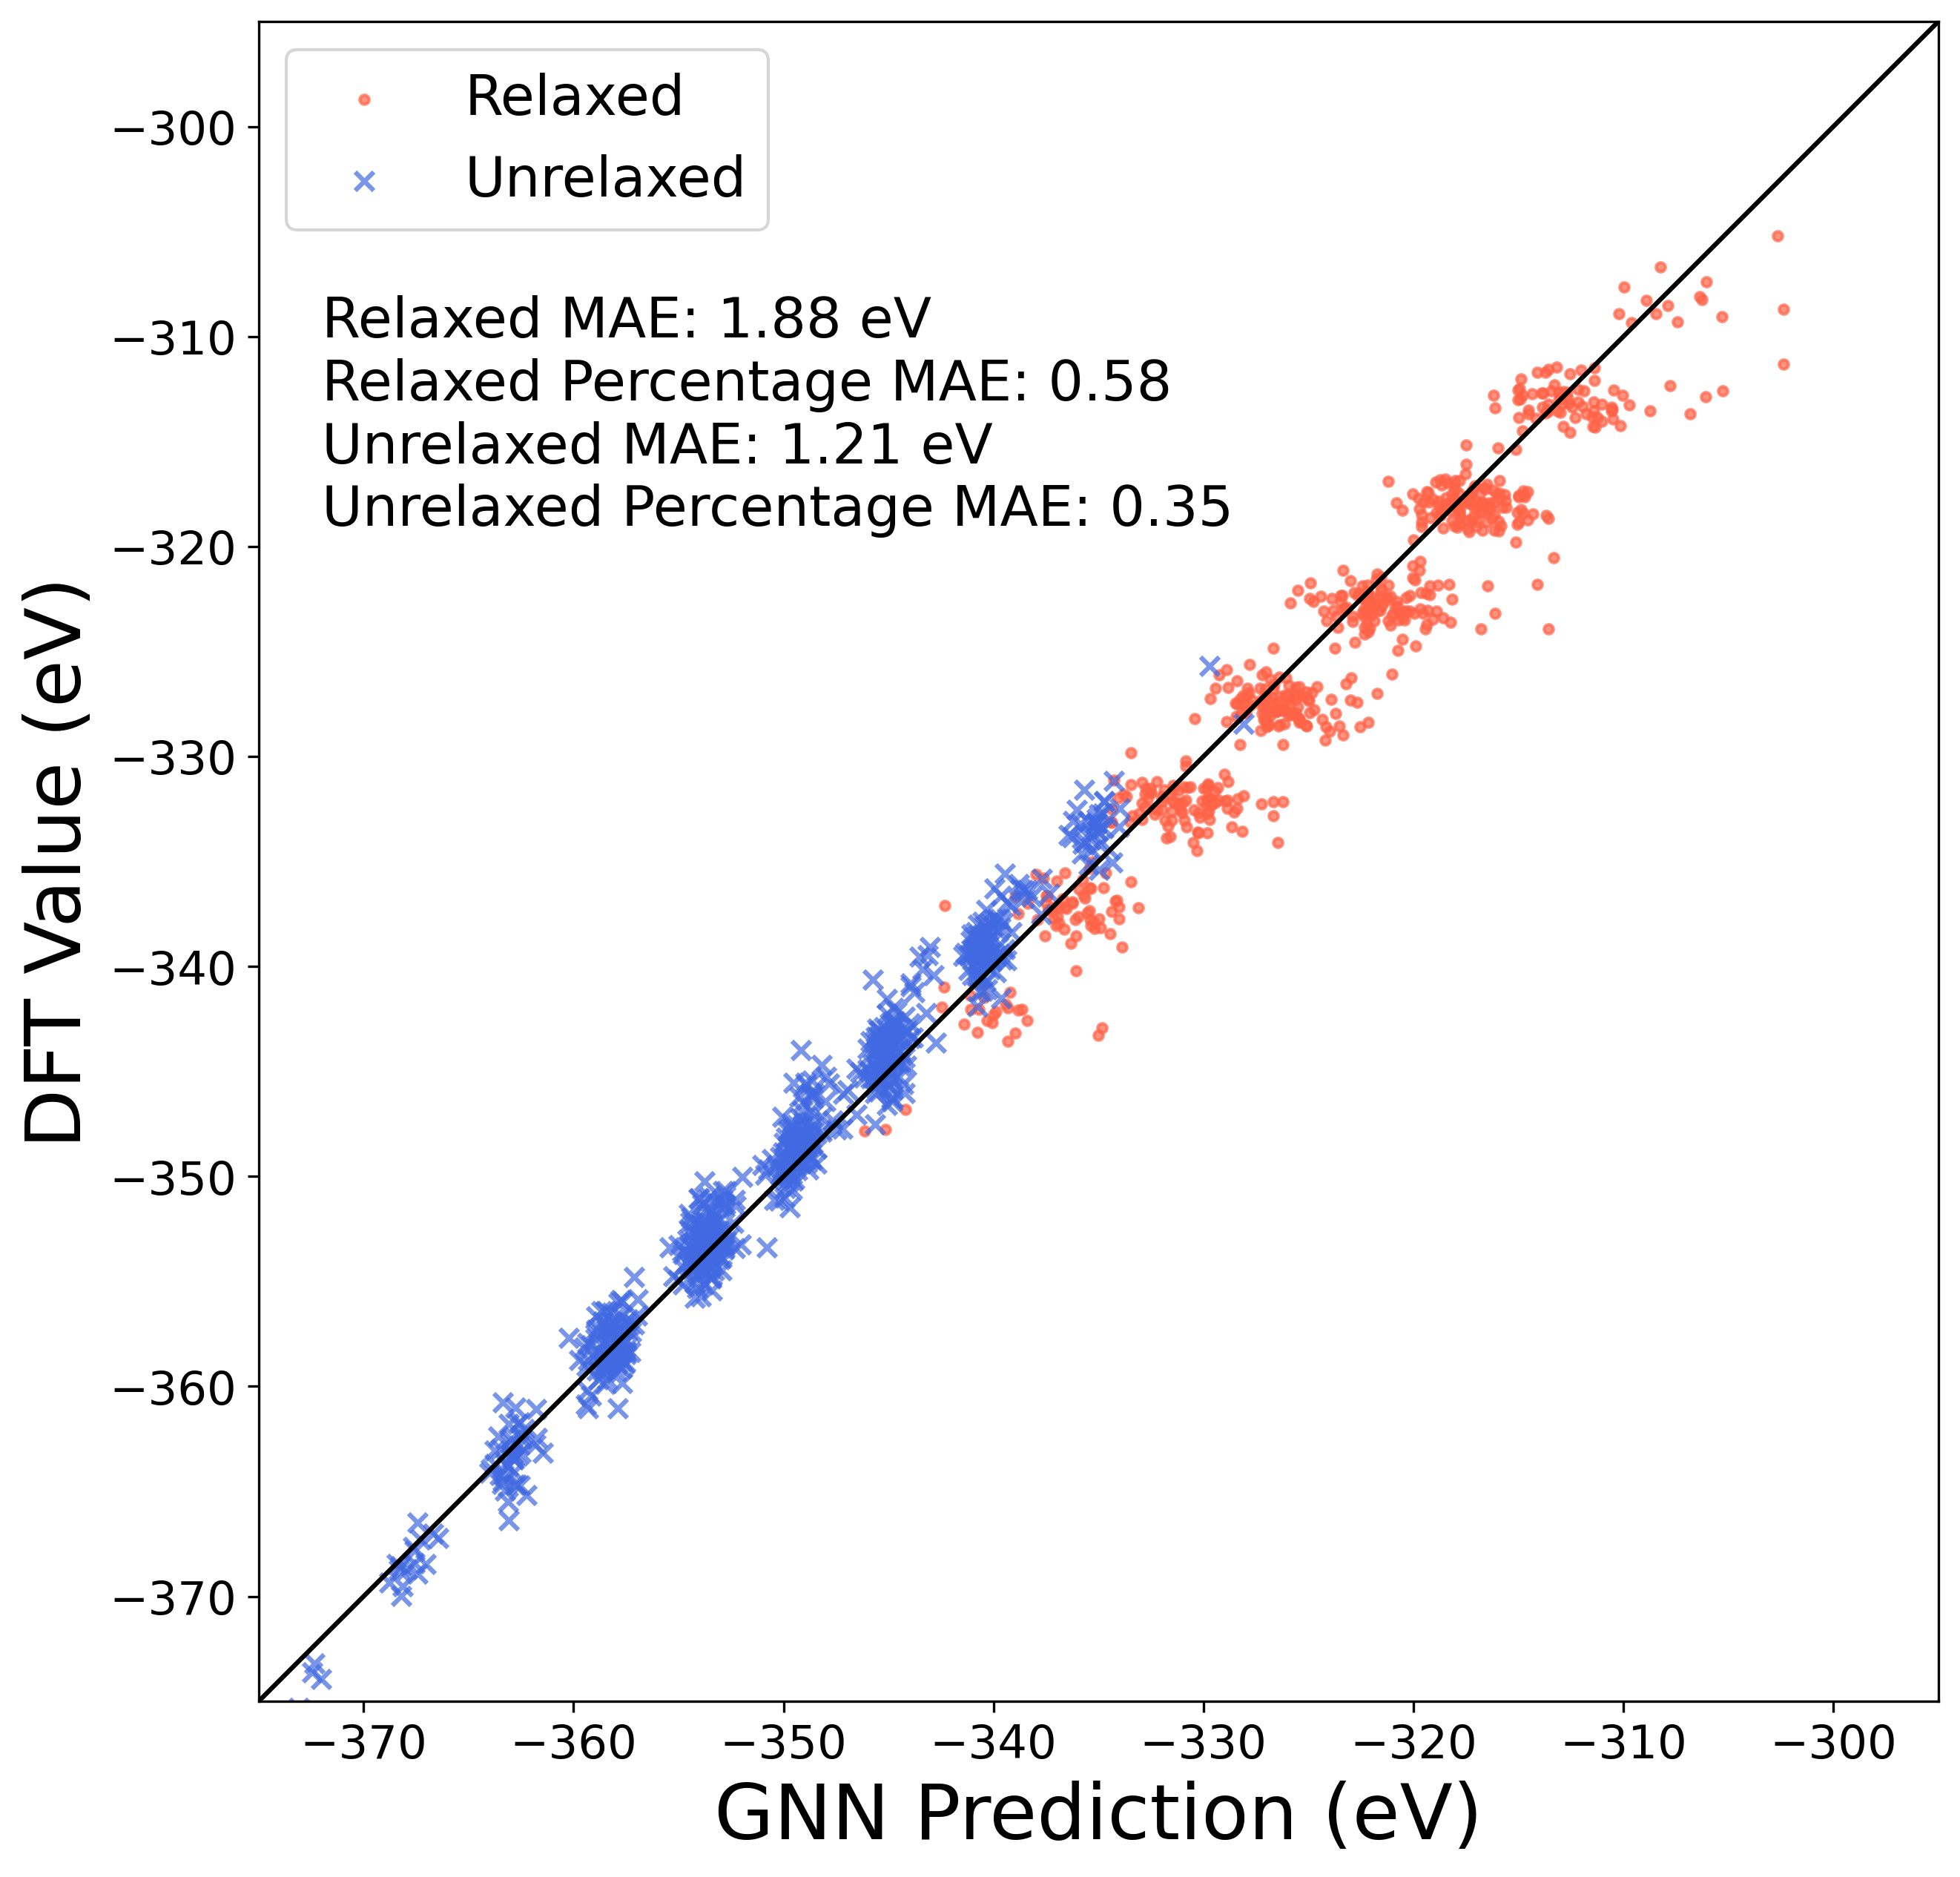

In [25]:
import numpy as np
import matplotlib.pyplot as plt

ref_line_offset = 11 # The y axis interception of the reference line

linear_x = np.linspace(-375, -295, num=100)
linear_y = np.linspace(-375, -295, num=100)

relax_percentage_error = np.array(relax_percentage_error)
relax_avg_per_error = np.sum(relax_percentage_error) / len(relax_percentage_error)

unrelax_percentage_error = np.array(unrelax_percentage_error)
unrelax_avg_per_error = np.sum(unrelax_percentage_error) / len(unrelax_percentage_error)

mae = torch.nn.L1Loss()
relax_mae_value = mae(torch.tensor(relax_labels), torch.tensor(relax_predictions)).item()
unrelax_mae_value = mae(torch.tensor(unrelax_labels), torch.tensor(unrelax_predictions)).item()

fig = plt.figure(figsize=(10, 10), dpi=300)
ax = fig.add_subplot(111)

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 15

plt.rc('font', size=18)   # controls default text sizes
plt.rc('axes', titlesize=25)         # fontsize of the axes title
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

ax.set_aspect('equal', adjustable='box')
ax.plot(linear_x, linear_y, color='k')
ax.scatter(relax_predictions, relax_labels, marker='.', alpha=0.7, color='tomato', label='Relaxed')
ax.scatter(unrelax_predictions, unrelax_labels, marker='x', alpha=0.7, color='royalblue', label='Unrelaxed')
ax.set_xlim(-375, -295)
ax.set_ylim(-375, -295)
ax.set_xlabel('GNN Prediction (eV)')
ax.set_ylabel('DFT Value (eV)')
ax.annotate(f'Relaxed MAE: {round(relax_mae_value, 2)} eV', xy=(-372, -310))
ax.annotate('Relaxed Percentage MAE: ' + str(round(relax_avg_per_error, 2)), xy=(-372, -313))
ax.annotate(f'Unrelaxed MAE: {round(unrelax_mae_value, 2)} eV', xy=(-372, -316))
ax.annotate('Unrelaxed Percentage MAE: ' + str(round(unrelax_avg_per_error, 2)), xy=(-372, -319))
ax.legend()
ax.legend()
print(f'Relaxed structures: {len(relax_predictions)}')
print(f'Unrelaxed structures: {len(unrelax_predictions)}')